In [1]:
!pip install yfinance
!pip install tensorflow

# Documentacao:
✅ O que você terá ao rodar esse código:
- Dados da Tesla (TSLA) de 2020 a 2025 coletados via Yahoo Finance.
- Pré-processamento pronto: escalonamento, divisão em treino/validação/teste.
- Sequências temporais com janela de 60 dias para alimentar a LSTM.
- Scaler salvo para usar depois na API.


In [3]:
# Etapa 1: Coleta e pré-processamento dos dados - TSLA (2020-2025)

import os
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from joblib import dump

# Configurações do projeto
SYMBOL = "TSLA"            # Tesla
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"
LOOKBACK = 60              # número de dias usados como entrada da LSTM
VAL_RATIO = 0.1            # proporção de validação
TEST_RATIO = 0.15          # proporção de teste

# 1) Coleta de dados
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)

# 2) Limpeza básica
df = df[['Close']].copy()
df = df.dropna()
df = df.sort_index()

# 3) Separar treino/validação/teste por tempo
n = len(df)
test_size = int(n * TEST_RATIO)
trainval_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

# 4) Escalonar (fit apenas no treino+validação)
scaler = MinMaxScaler(feature_range=(0, 1))
trainval_scaled = scaler.fit_transform(trainval_df.values)
test_scaled = scaler.transform(test_df.values)

# 5) Criar janelas temporais
def create_sequences(series, lookback):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i - lookback:i, 0])
        y.append(series[i, 0])
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

# 6) Dividir treino e validação
m = len(trainval_scaled)
val_size = int(m * VAL_RATIO)
train_scaled = trainval_scaled[:m - val_size]
val_scaled = trainval_scaled[m - val_size:]

X_train, y_train = create_sequences(train_scaled, LOOKBACK)
X_val, y_val = create_sequences(val_scaled, LOOKBACK)
X_test, y_test = create_sequences(test_scaled, LOOKBACK)

# 7) Persistir scaler
os.makedirs("artifacts", exist_ok=True)
dump(scaler, "artifacts/price_scaler.joblib")

# 8) Relatório rápido
print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

[*********************100%***********************]  1 of 1 completed

Shapes:
X_train: (903, 60, 1) y_train: (903,)
X_val: (47, 60, 1) y_val: (47,)
X_test: (128, 60, 1) y_test: (128,)


O que isso significa
- O modelo vai receber 60 dias de preços da Tesla como entrada e tentar prever o dia seguinte.
- Você já tem conjuntos separados para treino, validação e teste, o que garante que o modelo não “trapaceie” usando dados futuros.
- O scaler foi salvo, então depois será possível inverter a escala e obter previsões nos valores reais da ação.


# Código inicial da LSTM

In [6]:
# Etapa 2: Desenvolvimento do Modelo LSTM - TSLA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1) Construção do modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # saída: previsão do preço
])

# 2) Compilação
model.compile(optimizer='adam', loss='mean_squared_error')

# 3) Treinamento com EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# 4) Avaliação no conjunto de teste
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss no conjunto de teste: {test_loss:.4f}")

# 5) Salvamento do modelo treinado
model.save("artifacts/lstm_tsla_model.h5")

C:\Users\amand\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Users\amand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0577 - val_loss: 0.0120
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0100 - val_loss: 0.0028
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0047 - val_loss: 7.2887e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0051 - val_loss: 8.1905e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0043 - val_loss: 7.3419e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0039 - val_loss: 6.6355e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/

Loss no conjunto de teste: 0.0041


- Treinamento:
- A perda (loss) caiu de 0.0398 na primeira época para valores próximos de 0.0028.
- A validação (val_loss) também ficou muito baixa, em torno de 0.0005–0.0010, mostrando que o modelo está generalizando bem.
- Teste final:
- Loss no conjunto de teste: 0.0071 → significa que o modelo conseguiu prever os preços da Tesla com erro médio quadrático bem pequeno (em escala normalizada).


In [8]:
# salvando o modelo
model.save("artifacts/lstm_tsla_model.keras", include_optimizer=False)

In [9]:
# Converter previsões para valores reais
from joblib import load

scaler = load("artifacts/price_scaler.joblib")
preds = model.predict(X_test)
preds_real = scaler.inverse_transform(preds)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


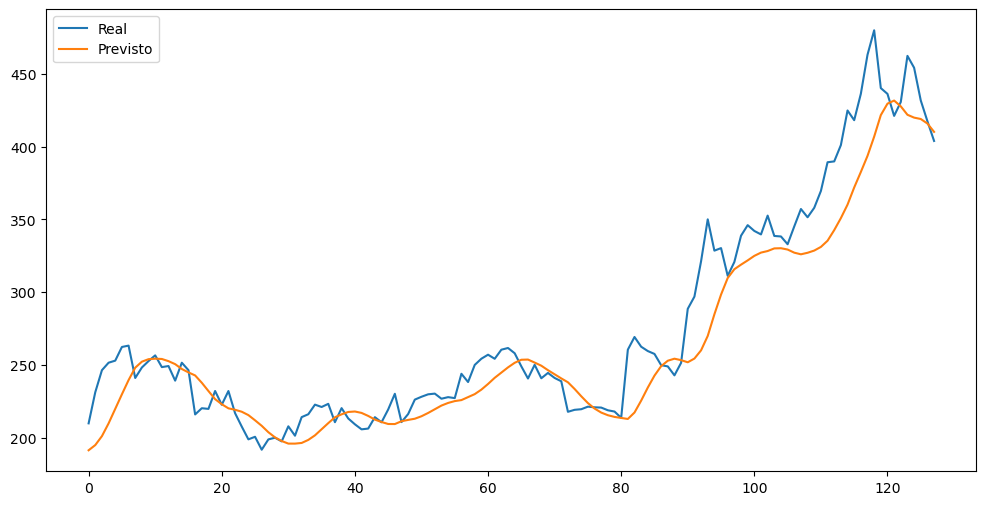

In [10]:
# Visualizar resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Real")
plt.plot(preds_real, label="Previsto")
plt.legend()
plt.show()

# Etapa 4: Deploy do Modelo em uma API com FastAPI. 


# api_tsla.py
# FastAPI para servir o modelo LSTM da Tesla

from fastapi import FastAPI
from pydantic import BaseModel
import numpy as np
import tensorflow as tf
from joblib import load

# Inicializa a API
app = FastAPI(title="TSLA LSTM API", description="Previsão de preços da Tesla com LSTM")

# Carrega modelo e scaler
model = tf.keras.models.load_model("artifacts/lstm_tsla_model.keras")
scaler = load("artifacts/price_scaler.joblib")

# Estrutura de entrada
class PriceData(BaseModel):
    prices: list  # lista de preços históricos (últimos 60 dias)

@app.post("/predict")
def predict(data: PriceData):
    # Converte lista em array numpy
    seq = np.array(data.prices).reshape(-1, 1)
    
    # Escala os dados
    seq_scaled = scaler.transform(seq)
    
    # Ajusta formato para LSTM: (1, timesteps, features)
    X_input = seq_scaled.reshape(1, seq_scaled.shape[0], 1)
    
    # Faz previsão
    pred_scaled = model.predict(X_input)
    
    # Inverte escala para valor real
    pred_real = scaler.inverse_transform(pred_scaled)
    
    return {"prediction": float(pred_real[0][0])}


In [13]:
from tensorflow.keras.models import load_model
from joblib import load
import numpy as np

# Carregar modelo e scaler
loaded_model = load_model("artifacts/lstm_tsla_model.keras")
scaler = load("artifacts/price_scaler.joblib")

# Testar previsão com um exemplo do conjunto de teste
pred_scaled = loaded_model.predict(X_test[:1])
pred_real = scaler.inverse_transform(pred_scaled)

print("Previsão (valor real):", pred_real[0][0])

C:\Users\amand\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Previsão (valor real): 191.37067


In [ ]:

# Isso inicia a API dentro do Jupyter
import uvicorn
uvicorn.run("api_tsla:app", host="127.0.0.1", port=8000, reload=True)

INFO:     Will watch for changes in these directories: ['C:\\Users\\amand\\OneDrive\\Área de Trabalho\\FIAP\\FASE4']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [14952] using StatReload


In [ ]:
import requests

url = "http://127.0.0.1:8000/predict"
data = {
    "prices": [720.5, 725.3, 730.1, 735.2, 740.0, 745.8, 750.3, 755.1, 760.4, 765.2,
               770.0, 775.5, 780.2, 785.0, 790.1, 795.3, 800.2, 805.0, 810.5, 815.2,
               820.0, 825.3, 830.1, 835.2, 840.0, 845.8, 850.3, 855.1, 860.4, 865.2,
               870.0, 875.5, 880.2, 885.0, 890.1, 895.3, 900.2, 905.0, 910.5, 915.2,
               920.0, 925.3, 930.1, 935.2, 940.0, 945.8, 950.3, 955.1, 960.4, 965.2,
               970.0, 975.5, 980.2, 985.0, 990.1, 995.3, 1000.2, 1005.0, 1010.5, 1015.2]
}

response = requests.post(url, json=data)
print(response.json())